In [1]:
import sys
sys.path.append('../')
sys.path.append('../WD_models')

### General
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from astropy.table import Table, Column, MaskedColumn, join
from astropy.table import vstack

from tqdm import tqdm
import pandas as pd
import WD_models

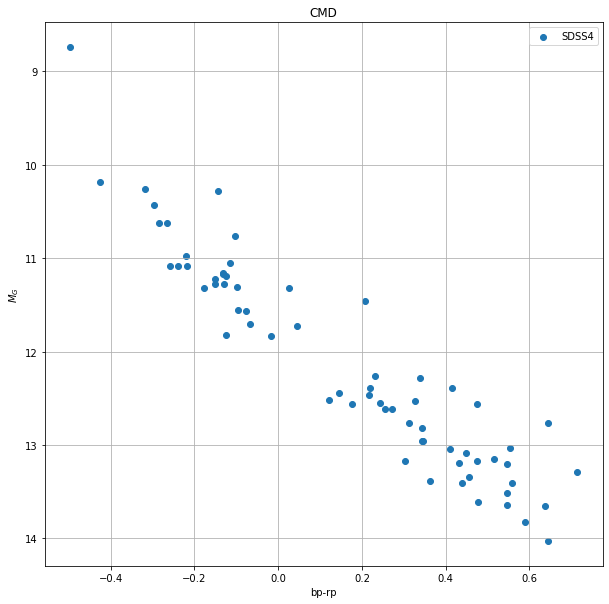

In [2]:
c1 = Table.read('data/03_wd_rv.fits')
c2 = Table.read('data/02_photometry.fits')

#c15 = Table.read('data/sdss5/sdss5_catalog_photo.fits')
#c25 = Table.read('data/sdss5/sdss5_catalog_rvs.fits')

plt.figure(figsize=(10,10))

plt.scatter(c1['wd_bp_rp'], c1['wd_m_g'], label='SDSS4')
#plt.scatter(c25['wd_bp_rp'], c25['wd_m_g'], label='SDSS5')

plt.grid()
plt.ylabel(r'$M_G$')
plt.xlabel(r'bp-rp')
plt.title(r'CMD')
plt.gca().invert_yaxis()
xmin, xmax = plt.xlim()

plt.legend()
plt.show()

catalog = join(c1, c2, keys='wd_source_id', join_type='inner')
catalog['program'] = [4 for i in range(len(catalog))]

#catalog2 = join(c15, c25, keys='wd_source_id', join_type='inner')
#catalog2['program'] = [5 for i in range(len(catalog2))]

#catalog2.remove_columns(['wd_pos_1_1','wd_pos_1_2', 'wd_pos_2_1','wd_pos_2_2'])
#catalog = vstack([catalog, catalog2])

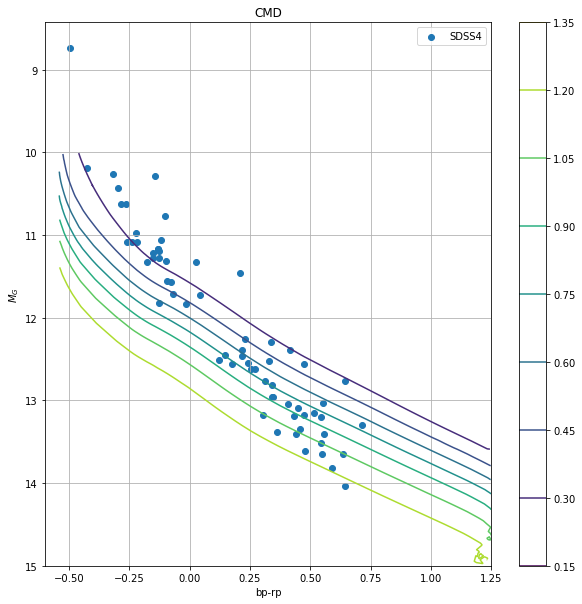

In [3]:
model = WD_models.load_model('f', 'f', 'f', 'H')
HR_grid = (-0.6, 1.25, 0.002, 10, 15, 0.01)
#model = WD_models.load_model('be', 'be', 'be', 'H', HR_grid=HR_grid)
extent = (HR_grid[0], HR_grid[1], HR_grid[3], HR_grid[4])

plt.figure(figsize=(10,10))

plt.scatter(c1['wd_bp_rp'], c1['wd_m_g'], label='SDSS4')
#plt.scatter(c25['wd_bp_rp'], c25['wd_m_g'], label='SDSS5')

plt.contour(model['grid_HR_to_mass'].T, extent=extent)

plt.grid()
plt.ylabel(r'$M_G$')
plt.xlabel(r'bp-rp')
plt.title(r'CMD')
plt.gca().invert_yaxis()
xmin, xmax = plt.xlim()

#plt.plot(np.linspace(xmin, xmax, num=100), wd_sep(np.linspace(xmin, xmax, num=100)))

plt.legend()
plt.colorbar()

plt.show()


In [4]:
model = WD_models.load_model('f', 'f', 'f', 'H')
font_model = model

c = 2.998e10
k = 1.38e-16
h = 6.626e-27
halpha = 6564.61
hbeta = 4862.68
hgamma = 4341.68
hdelta = 4102.89
speed_light = 299792458 #m/s
radius_sun = 6.957e8
mass_sun = 1.9884e30
newton_G = 6.674e-11
pc_to_m = 3.086775e16

def rv_from_radius(radarray, teffarray, lowmass = 'f', midmass = 'f', highmass = 'f'):
    
    if lowmass is not 'f' or highmass is not 'f' or midmass is not 'f':
        font_model = WD_models.load_model(lowmass, midmass, highmass, 'H')
    else:
        font_model = model

    #     font_model = WD_models.load_model(lowmass, midmass, highmass, 'H')


    g_acc = (10**font_model['logg'])/100
    rsun = np.sqrt(font_model['mass_array'] * mass_sun * newton_G / g_acc) / radius_sun
    
    rsun_teff_to_m = WD_models.interp_xy_z_func(x = rsun, y = 10**font_model['logteff'],\
                                                z = font_model['mass_array'], interp_type = 'linear')
    
    mass = rsun_teff_to_m(radarray, teffarray) * mass_sun
    radius = radarray * radius_sun
    rv = newton_G * mass / (speed_light * radius)

    return rv*1e-3

<>:19: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:19: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:19: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:19: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:19: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:19: SyntaxWarning: "is not" with a literal. Did you mean "!="?
C:\Users\arsen\AppData\Local\Temp/ipykernel_13420/1503571099.py:19: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if lowmass is not 'f' or highmass is not 'f' or midmass is not 'f':
C:\Users\arsen\AppData\Local\Temp/ipykernel_13420/1503571099.py:19: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if lowmass is not 'f' or highmass is not 'f' or midmass is not 'f':
C:\Users\arsen\AppData\Local\Temp/ipykernel_13420/1503571099.py:19: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if lowmass is not 'f' or highmass is not 'f' or midmass is not 'f':


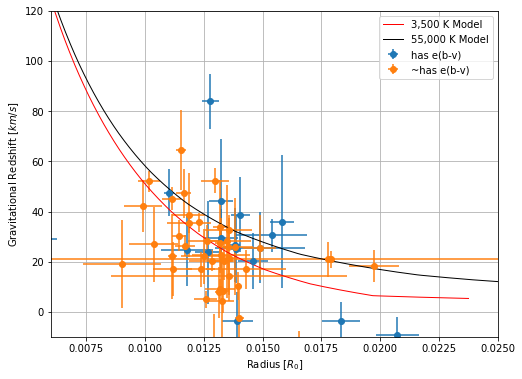

In [5]:
plt.figure(figsize=(8,6))

rsuns = np.linspace(0.006,0.025, 1000)

theoretical_rvs = rv_from_radius(rsuns, 3500, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'red', linestyle = '-', label = '3,500 K Model', linewidth = 1)

theoretical_rvs = rv_from_radius(rsuns, 55000, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'black', label = '55,000 K Model', linewidth = 1)

plt.errorbar(catalog[catalog['E(B-V)'] != 0]['radius'], catalog[catalog['E(B-V)'] != 0]['g_redshift'], 
             xerr = catalog[catalog['E(B-V)'] != 0]['e_radius'], yerr=catalog[catalog['E(B-V)'] != 0]['eg_redshift'], fmt='o', label='has e(b-v)')
plt.errorbar(catalog[catalog['E(B-V)'] == 0]['radius'], catalog[catalog['E(B-V)'] == 0]['g_redshift'], 
             xerr = catalog[catalog['E(B-V)'] == 0]['e_radius'], yerr=catalog[catalog['E(B-V)'] == 0]['eg_redshift'], fmt='o', label='~has e(b-v)')

plt.grid()
plt.xlabel(r'Radius $[R_{0}]$')
plt.ylabel(r'Gravitational Redshift $[km/s]$')
plt.xlim(0.006, 0.025)
plt.ylim(-10, 120)
plt.legend()

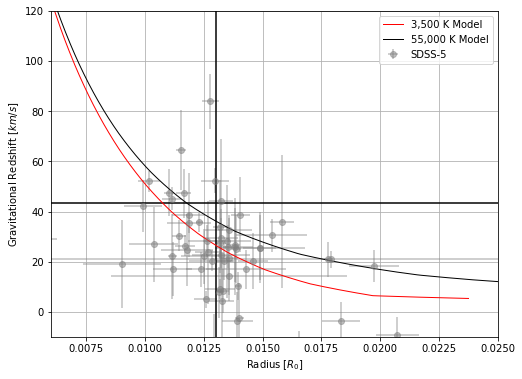

In [6]:
from scipy.stats import gaussian_kde

plt.figure(figsize=(8,6))

rsuns = np.linspace(0.006,0.025, 1000)

xy = np.vstack([catalog['radius'],catalog['g_redshift']])
z = gaussian_kde(xy)(xy)

theoretical_rvs = rv_from_radius(rsuns, 3500, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'red', linestyle = '-', label = '3,500 K Model', linewidth = 1)

theoretical_rvs = rv_from_radius(rsuns, 55000, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'black', label = '55,000 K Model', linewidth = 1)

"""
plt.errorbar(catalog[catalog['program'] == 4]['radius'], catalog[catalog['program'] == 4]['g_redshift'], 
             xerr = catalog[catalog['program'] == 4]['e_radius'], yerr=catalog[catalog['program'] == 4]['eg_redshift'], 
             fmt='o', label = 'SDSS-4', alpha = 0.5)
plt.errorbar(catalog[catalog['program'] == 5]['radius'], catalog[catalog['program'] == 5]['g_redshift'], 
             xerr = catalog[catalog['program'] == 5]['e_radius'], yerr=catalog[catalog['program'] == 5]['eg_redshift'], 
             fmt='o', label = 'SDSS-5', alpha = 0.5)
"""

plt.errorbar(catalog['radius'], catalog['g_redshift'], 
             xerr = catalog['e_radius'], yerr=catalog['eg_redshift'], 
             fmt='o', label = 'SDSS-5', alpha = 0.5, color = 'grey')

plt.hlines(np.mean(catalog['g_redshift']), 0.006, 0.025, colors='black')
plt.vlines(np.mean(catalog['radius']), -10, 120, colors='black')

plt.grid()
plt.xlabel(r'Radius $[R_{0}]$')
plt.ylabel(r'Gravitational Redshift $[km/s]$')
plt.xlim(0.006, 0.025)
plt.ylim(-10, 120)
plt.legend()
#plt.savefig('plots/photometry/gredshift_vs_radius.jpg')

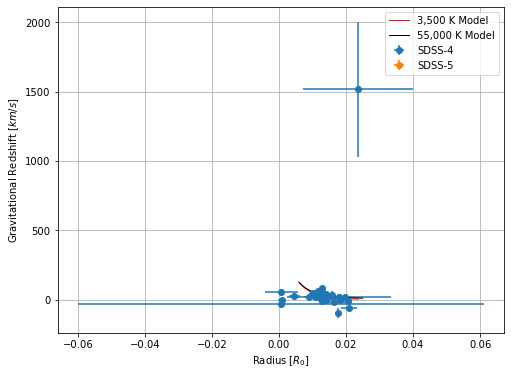

In [7]:
plt.figure(figsize=(8,6))

rsuns = np.linspace(0.006,0.025, 1000)

theoretical_rvs = rv_from_radius(rsuns, 3500, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'red', linestyle = '-', label = '3,500 K Model', linewidth = 1)

theoretical_rvs = rv_from_radius(rsuns, 55000, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'black', label = '55,000 K Model', linewidth = 1)

plt.errorbar(catalog[catalog['program'] == 4]['radius'], catalog[catalog['program'] == 4]['g_redshift'], 
             xerr = catalog[catalog['program'] == 4]['e_radius'], yerr=catalog[catalog['program'] == 4]['eg_redshift'], fmt='o', label = 'SDSS-4')
plt.errorbar(catalog[catalog['program'] == 5]['radius'], catalog[catalog['program'] == 5]['g_redshift'], 
             xerr = catalog[catalog['program'] == 5]['e_radius'], yerr=catalog[catalog['program'] == 5]['eg_redshift'], fmt='o', label = 'SDSS-5')

plt.grid()
plt.xlabel(r'Radius $[R_{0}]$')
plt.ylabel(r'Gravitational Redshift $[km/s]$')
#plt.xlim(0.006, 0.035)
#plt.ylim(-10, 120)
plt.legend()

In [8]:
#catalog[['wd_coords', 'clean', 'insideMask', 'converged', 'reliable_dist']].pprint(100,100)

np.all([catalog['program'] == 5], axis = 0)
clean = np.logical_or(catalog['clean'], np.all([catalog['program'] == 5], axis = 0))

66
20.85055144360322
11.56531586241371


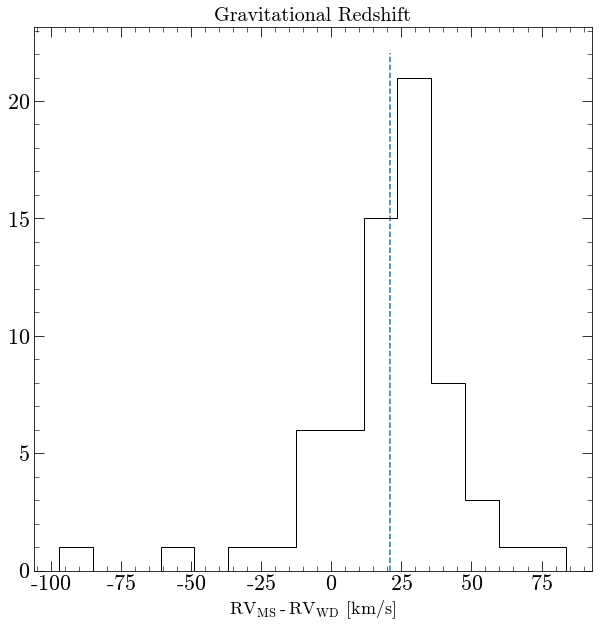

In [9]:
plt.figure(figsize=(10,10))
plt.style.use('./stefan.mplstyle')

#plt.grid()
plt.hist(catalog[catalog['g_redshift'] < 1000]['g_redshift'], bins = 15, histtype='step', color='black')
ymin, ymax = plt.ylim()
plt.vlines(np.mean(catalog[catalog['g_redshift'] < 1000]['g_redshift']), ymin, ymax, linestyles='dashed')
plt.title('Gravitational Redshift', fontsize=20)
plt.xlabel(r'$RV_{MS} - RV_{WD}$ $[km/s]$', fontsize=18)

print(len(catalog))
print(np.mean(catalog[catalog['g_redshift'] < 1000]['g_redshift']))
print(np.mean(catalog[catalog['g_redshift'] < 1000]['eg_redshift']))

plt.savefig('figs/fig1_vg_hist.pdf')

34


FileNotFoundError: [Errno 2] No such file or directory: '../gemini/fig1.png'

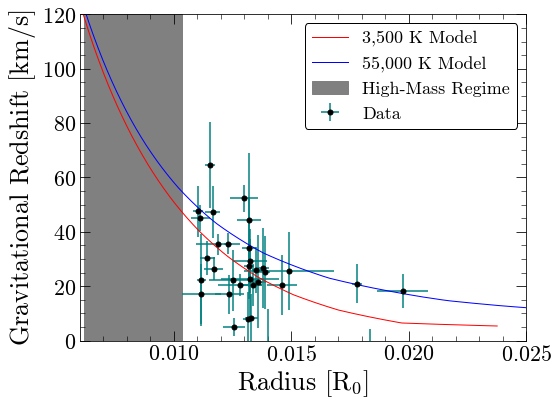

In [10]:
rechi = np.all([catalog['rechi'] < 5], axis = 0)
redchi = np.all([catalog['redchi'] < 5], axis = 0)

mask = np.all([redchi, rechi, clean], axis = 0)

plt.figure(figsize=(8,6))
plt.style.use('./stefan.mplstyle')


rsuns = np.linspace(0.006,0.025, 1000)

theoretical_rvs = rv_from_radius(rsuns, 3500, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'red', linestyle = '-', label = '3,500 K Model', linewidth = 1)

theoretical_rvs = rv_from_radius(rsuns, 55000, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'blue', label = '55,000 K Model', linewidth = 1)

#plt.errorbar(catalog['radius'][~mask], catalog['g_redshift'][~mask], xerr = catalog['e_radius'][~mask], yerr=catalog['eg_redshift'][~mask], fmt='o', label = 'Raw Data')
#plt.errorbar(catalog['radius'][~mask], catalog['g_redshift'][~mask], fmt='o', label = 'Raw Data')
plt.errorbar(catalog['radius'][mask], catalog['g_redshift'][mask], xerr = catalog['e_radius'][mask], yerr=catalog['eg_redshift'][mask], fmt='o', label = 'Data', color='black', ecolor = 'teal')

#plt.hlines(np.mean(catalog['g_redshift'][mask]), 0.006, 0.025, colors='black')
#plt.vlines(np.mean(catalog['radius'][mask]), -10, 120, colors='black')

plt.axhspan(0, 120, xmin=0.01, xmax = 0.23, label = 'High-Mass Regime', color = 'grey')

print(len(catalog['g_redshift'][mask]))

#plt.grid()
plt.xlabel(r'Radius $[R_{0}]$')
plt.ylabel(r'Gravitational Redshift $[km/s]$')
plt.xlim(0.006, 0.025)
plt.ylim(0, 120)
plt.legend()

plt.savefig('../gemini/fig1.png')

catalog[['wd_catalog_id', 'rv_id', 'radius', 'e_radius', 'g_redshift', 'eg_redshift', 'redchi', 'rechi', 'corv_teff', 'program']][mask].pprint(100, 200)
#catalog[['wd_catalog_id', 'radius', 'e_radius', 'g_redshift', 'eg_redshift', 'redchi', 'rechi', 'program']][~mask].pprint(100, 200)

In [ ]:
masked = catalog[mask].copy()

masked['teff'] = [np.mean([masked['corv_teff'][i], masked['phot_teff_1'][i]]) for i in range(len(masked))]
masked['e_teff'] = [np.mean([masked['e_teff'][i], masked['e_phot_teff_1'][i]]) for i in range(len(masked))]

bins = 10
labels = range(bins)

masked['teff_bin'] = pd.cut(masked['teff'], bins=bins)
masked['teff_group'] = pd.cut(masked['teff'], bins=bins, labels=labels)

In [ ]:
from astropy.table import unique, Table

unique(masked[[ 'teff_bin', 'teff_group']]).pprint(400,100)

In [ ]:
dat_grouped = masked['radius', 'e_radius', 'g_redshift', 'eg_redshift','teff','teff_group'].group_by(masked['teff_group'])
dat_binned = dat_grouped.groups.aggregate(np.mean)

In [ ]:
dat_binned.pprint(200,200)

In [ ]:
plt.figure(figsize=(12,10))

rsuns = np.linspace(0.006,0.025, 1000)

theoretical_rvs = rv_from_radius(rsuns, 3500, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'red', linestyle = '-', label = '3,500 K Model', linewidth = 1)

theoretical_rvs = rv_from_radius(rsuns, 55000, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'black', label = '55,000 K Model', linewidth = 1)

plt.errorbar(dat_binned['radius'], dat_binned['g_redshift'], xerr = dat_binned['e_radius'], yerr=dat_binned['eg_redshift'], fmt='o', label = 'Selected Data')

#plt.hlines(np.mean(dat_binned['g_redshift']), 0.006, 0.025, colors='black')
#plt.vlines(np.mean(dat_binned['radius']), -10, 120, colors='black')

#print(np.mean(catalog['g_redshift'][mask]))

for i in range(len(dat_binned['radius'])):
    x = dat_binned['radius'][i]
    y = dat_binned['g_redshift'][i]
    #plt.plot(x, y, 'bo')
    
    if (0.006 < x < 0.025) and (0 < y < 120):
        plt.text(x * (1 + 0.01), y * (1 - 0.01) , dat_binned['teff_group'][i], fontsize=11)

plt.grid()
plt.xlabel(r'Radius $[R_{0}]$')
plt.ylabel(r'Gravitational Redshift $[km/s]$')
#plt.xlim(0.006, 0.025)
#plt.ylim(0, 120)
plt.legend()